# Triton Examples

## Prerequisites

 * For the test data you will need to install `torch`, `torchvision` and `tensorflow`
 * For the visualization `matplotlib`
 * For calling the service `curl`


## Setup Seldon Core

Follow the instructions to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core).

 Then port-forward to that ingress on localhost:8003 in a separate terminal either with:

 * Ambassador: `kubectl port-forward $(kubectl get pods -n seldon -l app.kubernetes.io/name=ambassador -o jsonpath='{.items[0].metadata.name}') -n seldon 8003:8080`
 * Istio: `kubectl port-forward $(kubectl get pods -l istio=ingressgateway -n istio-system -o jsonpath='{.items[0].metadata.name}') -n istio-system 8003:8080`

### Create Namespace for experimentation

We will first set up the namespace of Seldon where we will be deploying all our models

In [1]:
!kubectl create namespace seldon

namespace/seldon created


And then we will set the current workspace to use the seldon namespace so all our commands are run there by default (instead of running everything in the default namespace.)

In [1]:
!kubectl config set-context $(kubectl config current-context) --namespace=seldon

Context "kind-kind" modified.


In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf

train, test = tf.keras.datasets.cifar10.load_data()
X_test, y_test = test
X_test = X_test.astype("float32") / 255
print(X_test.shape, y_test.shape)
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

2022-02-01 16:53:52.029992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-01 16:53:52.030017: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(10000, 32, 32, 3) (10000, 1)


## Triton Model Naming

You need to name the model in the graph with the same name as the triton model loaded as this name will be used in the path to triton.

## Tensorflow CIFAR10 Model


In [3]:
%%writefile resources/triton_tf_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/tf_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Writing resources/triton_tf_cifar10.yaml


In [4]:
!kubectl apply -f resources/triton_tf_cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


In [5]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-default-0-cifar10" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-default-0-cifar10" successfully rolled out


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63906  100   339  100 63567    696   127k --:--:-- --:--:-- --:--:--  127k


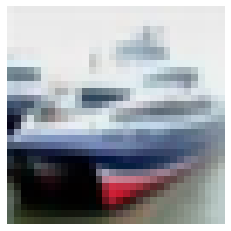

class: ship
prediction: ship


In [6]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 1
test_example = X_test[idx : idx + 1].tolist()
payload = (
    '{"inputs":[{"name":"input_1","datatype":"FP32","shape":[1, 32, 32, 3],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()
print("class:", class_names[y_test[idx][0]])
print("prediction:", class_names[arr.argmax()])

In [7]:
!kubectl delete -f resources/triton_tf_cifar10.yaml

seldondeployment.machinelearning.seldon.io "cifar10" deleted


## ONNX CIFAR10 Model


In [8]:
%%writefile resources/triton_onnx_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/onnx_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Writing resources/triton_onnx_cifar10.yaml


In [9]:
!kubectl apply -f resources/triton_onnx_cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


In [10]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-default-0-cifar10" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-default-0-cifar10" successfully rolled out


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63913  100   344  100 63569  20081  3623k --:--:-- --:--:-- --:--:-- 3651k


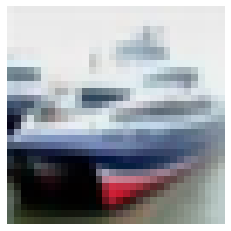

class: ship
prediction: ship


In [11]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 1
test_example = X_test[idx : idx + 1].tolist()
payload = (
    '{"inputs":[{"name":"input_1:0","datatype":"FP32","shape":[1, 32, 32, 3],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()
print("class:", class_names[y_test[idx][0]])
print("prediction:", class_names[arr.argmax()])

In [12]:
!kubectl delete -f resources/triton_onnx_cifar10.yaml

seldondeployment.machinelearning.seldon.io "cifar10" deleted


## TorchScript CIFAR10 Model


In [13]:
%%writefile resources/triton_pt_cifar10.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: cifar10
  namespace: seldon
spec:
  annotations:
    seldon.io/engine-seldon-log-messages-externally: "true"
  name: resnet32
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/pytorch_cifar10
      name: cifar10
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Writing resources/triton_pt_cifar10.yaml


In [14]:
!kubectl apply -f resources/triton_pt_cifar10.yaml

seldondeployment.machinelearning.seldon.io/cifar10 created


In [15]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=cifar10 -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "cifar10-default-0-cifar10" rollout to finish: 0 of 1 updated replicas are available...
deployment "cifar10-default-0-cifar10" successfully rolled out


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=10, shuffle=False, num_workers=2
)
for data in testloader:
    images, labels = data
    break

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63672  100   309  100 63363   2174   435k --:--:-- --:--:-- --:--:--  432k


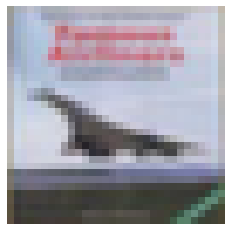

class: airplane
prediction: airplane


In [18]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 3
test_example = images[idx : idx + 1]
test_example = test_example.tolist()
payload = (
    '{"inputs":[{"name":"input__0","datatype":"FP32","shape":[1, 3, 32, 32],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/cifar10/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()

print("class:", class_names[labels[idx]])
print("prediction:", class_names[arr.argmax()])

In [19]:
!kubectl delete -f resources/triton_pt_cifar10.yaml

seldondeployment.machinelearning.seldon.io "cifar10" deleted


## Multi-Model Serving


In [20]:
%%writefile resources/triton_multi.yaml
apiVersion: machinelearning.seldon.io/v1
kind: SeldonDeployment
metadata:
  name: multi
  namespace: seldon
spec:
  predictors:
  - graph:
      implementation: TRITON_SERVER
      logger:
        mode: all
      modelUri: gs://seldon-models/triton/multi
      name: multi
      type: MODEL
    name: default
    replicas: 1
  protocol: v2

Writing resources/triton_multi.yaml


In [21]:
!kubectl apply -f resources/triton_multi.yaml

seldondeployment.machinelearning.seldon.io/multi created


In [22]:
!kubectl rollout status -n seldon deploy/$(kubectl get deploy -l seldon-deployment-id=multi -n seldon -o jsonpath='{.items[0].metadata.name}')

Waiting for deployment "multi-default-0-multi" rollout to finish: 0 of 1 updated replicas are available...
deployment "multi-default-0-multi" successfully rolled out


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63906  100   339  100 63567    752   137k --:--:-- --:--:-- --:--:--  137k


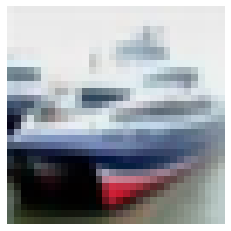

class: ship
prediction: ship


In [23]:
import json
from subprocess import PIPE, Popen, run

import numpy as np

idx = 1
test_example = X_test[idx : idx + 1].tolist()
payload = (
    '{"inputs":[{"name":"input_1","datatype":"FP32","shape":[1, 32, 32, 3],"data":'
    + f"{test_example}"
    + "}]}"
)
cmd = f"""curl -d '{payload}' \
   http://localhost:8003/seldon/seldon/multi/v2/models/cifar10/infer \
   -H "Content-Type: application/json"
"""
ret = Popen(cmd, shell=True, stdout=PIPE)
raw = ret.stdout.read().decode("utf-8")
res = json.loads(raw)
arr = np.array(res["outputs"][0]["data"])
X = X_test[idx].reshape(1, 32, 32, 3)
plt.imshow(X.reshape(32, 32, 3))
plt.axis("off")
plt.show()
print("class:", class_names[y_test[idx][0]])
print("prediction:", class_names[arr.argmax()])

In [24]:
X=!curl -s -d '{"inputs":[{"name":"INPUT0","data":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"datatype":"INT32","shape":[1,16]},{"name":"INPUT1","data":[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],"datatype":"INT32","shape":[1,16]}]}'  \
        -X POST http://0.0.0.0:8003/seldon/seldon/multi/v2/models/simple/infer \
        -H "Content-Type: application/json"
d=json.loads(X[0])
print(d)
assert(d["outputs"][0]["data"][0]==2)

{'model_name': 'simple', 'model_version': '1', 'outputs': [{'name': 'OUTPUT0', 'datatype': 'INT32', 'shape': [1, 16], 'data': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]}, {'name': 'OUTPUT1', 'datatype': 'INT32', 'shape': [1, 16], 'data': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}]}


In [26]:
!kubectl delete -f resources/triton_multi.yaml

seldondeployment.machinelearning.seldon.io "multi" deleted
